# Generate ERA5 forcing file for whole Pacific Region

## Data and Packages

In [1]:
time_resolution = 86400 # for monthly data; change to 3600 for hourly data

import xarray as xr 
import numpy as np
import pandas as pd

months = [1, 4, 7, 10]
lat_min = -45
lat_max = 45
lon_min = 100
lon_max = 290

In [5]:
geo = xr.open_dataset("coszen_data.nc")
pressure_avg = xr.open_dataset("~/Downloads/era5/monthly/pressure_avg_monthly_45.nc") # already preprocessed since so big
surface = xr.open_mfdataset("/Users/julianschmitt/Downloads/era5/monthly/global_surface_20yr.nc")

In [6]:
surface = surface.where((surface.latitude > lat_min) & (surface.latitude < lat_max) & (surface.longitude > lon_min) & (surface.longitude < lon_max), drop =True)
geo = geo.where((geo.lat > lat_min) & (geo.lat < lat_max) & (geo.lon > lon_min) & (geo.lon < lon_max), drop =True)

# # monthly time mean
# pressure["date"] = pd.to_datetime(pressure["date"].astype(str), format="%Y%m%d")
surface["date"] = pd.to_datetime(surface["date"].astype(str), format="%Y%m%d")
# pressure_avg = pressure.groupby("date.month").mean()
surface_avg = surface.groupby("date.month").mean()
surface_avg = surface_avg.load()


## Compute per point

In [36]:
def get_horizontal_tendencies(lon, lat, column_ds):
    """Computes horizontal tendencies for temperature and specific humidity at a given location.
    Args:
    lon: site longitude
    lat: site latitude
    column_ds: xarray dataset containing ERA5 data at pressure levels 
    """
    west = column_ds.where((column_ds.latitude == lat) & (column_ds.longitude == lon - .25), drop = True).isel(latitude=0, longitude=0).squeeze()
    east = column_ds.where((column_ds.latitude == lat) & (column_ds.longitude == lon + .25), drop = True).isel(latitude=0, longitude=0).squeeze()
    north = column_ds.where((column_ds.latitude == lat + .25) & (column_ds.longitude == lon), drop = True).isel(latitude=0, longitude=0).squeeze()
    south = column_ds.where((column_ds.latitude == lat - .25) & (column_ds.longitude == lon), drop = True).isel(latitude=0, longitude=0).squeeze()
    center = column_ds.where((column_ds.latitude == lat) & (column_ds.longitude == lon), drop = True).isel(latitude=0, longitude=0).squeeze()
    
    # convert to radians for gradient calculation 
    rearth = 6378e3
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon - 360)
    coslat = np.cos(lat)
    dx = 2 * np.pi * rearth * coslat / 360 * .25# per .25 degree longitude 
    dy = 2 * np.pi * rearth / 360 * .25# per .25 degree latitude

    # compute advective tendencies
    # Temperature
    tntha = center.u * (east.t - west.t) / (2 * dx) + center.v * (north.t - south.t) / (2 * dy)
    # specific humidity
    tnhusha = center.u * (east.q - west.q) / (2 * dx) + center.v * (north.q - south.q) / (2 * dy)

    return tntha, tnhusha

#get_tendencies(lon, lat, col)[0]

def get_vertical_tendencies(column_ds, var, vertvar = "wa"):
    """
    Calculate the temperature and specific humidity vertical tendencies as a function of levels
    using vertical advection. Here we take the tendency over the geopotential height not the height in meters
    """
    tntva_trend = []
    # Loop through each pressure level
    num_levels = column_ds[vertvar].shape[0]  # Number of vertical levels

    for i in range(num_levels):
        if i == 0:  # Bottom level (forward difference)
            tntva = column_ds[vertvar][i] * (column_ds[var][i+1] - column_ds[var][i]) / (column_ds.zg[i+1] - column_ds.zg[i])
        
        elif i == num_levels - 1:  # Top level (backward difference)
            tntva = column_ds[vertvar][i] * (column_ds[var][i] - column_ds[var][i-1]) / (column_ds.zg[i] - column_ds.zg[i-1])
        
        else:  # Middle levels (surface_dsed difference)
            tntva = column_ds[vertvar][i] * (column_ds[var][i+1] - column_ds[var][i-1]) / ((column_ds.zg[i+1] - column_ds.zg[i-1]))

        tntva = tntva.assign_coords(pressure_level=column_ds.pressure_level[i])

        # Append the result to the trend list
        tntva_trend.append(tntva)
    
    # Convert the trend list to an xarray object, correctly indexed by pressure levels
    tntva_trend = xr.concat(tntva_trend, dim="pressure_level")
    #tntva_trend = tntva_trend.assign_coords(pressure_level=column_ds.pressure_level)

    return tntva_trend

def get_forcing_data(lat, lon, column_ds, surface_ds, geo = geo):


    sitesf = surface_ds.where((surface_ds.latitude == lat) & (surface_ds.longitude == lon), drop = True)
    sitecol = column_ds.where((column_ds.latitude == lat) & (column_ds.longitude == lon), drop = True)

    ##### get column data #####
    # compute temperature
    R_d = 287.05  # Specific gas constant for dry air (J/(kg·K))
    g = 9.807  # Gravitational acceleration (m/s²)
    pressure = sitecol.pressure_level * 100  # Convert to Pa
    pressure_broadcasted = pressure.broadcast_like(column_ds.t)
    # Compute air density using the ideal gas law: rho = P / (R_d * T)
    rho = pressure_broadcasted / (R_d * column_ds.t)
    sitecol["rho"] = rho

    ##### get surface data #####
    #coszen = xr.open_dataset("/Users/julianschmitt/Downloads/HadGEM2-A_amip.2004-2008.07.nc", group = f"site{group}").coszen
    # sitecol["coszen"] = coszen
    #coszen = geo.where(geo["site"] == cfsite, drop = True)

    # rescale TOA incident radiation to w/m2 by dividing by the time step of ERA5 (1 hour)
    sitesf["tisr"] = sitesf["tisr"] / time_resolution

    #### Combine data ####
    sitedata = xr.merge([sitecol[["z", "t", "rho", "u", "v", "w", "q"]], 
                         sitesf[["slhf", "sshf", "tisr", "skt"]]])
    
    # convert sensible and latent heat fluxes to W/m2; flip sign to match climaatmos practices 
    sitedata["slhf"] = - sitedata["slhf"] / time_resolution
    sitedata["sshf"] = - sitedata["sshf"] / time_resolution

    sitedata = sitedata.rename({"t": "ta", "u": "ua", "v": "va", "w": "wa", "q": "hus", "slhf": "hfls", "sshf": "hfss", "skt": "ts", "tisr": "rsdt", "z": "zg"})
    sitedata["z"] = sitedata["zg"] / g # convert geopotential (zg) to height in meters (z)

    # remove latitude/longitude dependence
    sitedata = sitedata.squeeze()

    # calculate tendency terms
    sitedata["wap"] = sitedata["wa"] * sitedata["rho"]
    # temperature vertical tendency due to vertical advection
    sitedata["tntva"] = get_vertical_tendencies(sitedata, "ta")
    # specific humidity vertical tendency due to vertical advection
    sitedata["tnhusva"] = get_vertical_tendencies(sitedata, "hus")

    # compute horizontal tendencies
    tntha, tnhusha = get_horizontal_tendencies(lon, lat, column_ds)

    sitedata["tntha"] = tntha
    sitedata["tnhusha"] = tnhusha
    
    return sitedata


## Compute Per location in the Pacific

In [89]:
pressure_avg.longitude

<xarray.DataArray 'longitude' (longitude: 439)> Size: 4kB
array([180.25, 180.5 , 180.75, ..., 289.25, 289.5 , 289.75])
Coordinates:
    number     int64 8B ...
  * longitude  (longitude) float64 4kB 180.2 180.5 180.8 ... 289.2 289.5 289.8
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude

In [92]:
# list locations in pacific 
# consider july first 
month = 7
pressure_ds = pressure_avg.sel(month = month, drop = True)
surface_ds = surface_avg.sel(month = month, drop = True)
#geo_ds = geo.sel(date = month, drop=True)
site_data_ar = []
for latitude in range(0, 44, 1):
    for longitude in range(181, 280, 1):
        if (latitude + longitude) % 100 == 0:
            print(latitude, longitude)
        # compute data for each site
        site_data = get_forcing_data(latitude, longitude, pressure_ds, surface_ds)
        site_data_ar.append(site_data)


0 185
0 190
0 195
0 200
0 205
0 210
0 215
0 220
0 225
0 230
0 235
0 240
0 245
0 250
0 255
0 260
0 265
0 270
0 275
5 185
5 190
5 195
5 200
5 205
5 210
5 215
5 220
5 225
5 230
5 235
5 240
5 245
5 250
5 255
5 260
5 265
5 270
5 275
10 185
10 190
10 195
10 200
10 205
10 210
10 215
10 220
10 225
10 230
10 235
10 240
10 245
10 250
10 255
10 260
10 265
10 270
10 275
15 185
15 190
15 195
15 200
15 205
15 210
15 215
15 220
15 225
15 230
15 235
15 240
15 245
15 250
15 255
15 260
15 265
15 270
15 275
20 185
20 190
20 195
20 200
20 205
20 210
20 215
20 220
20 225
20 230
20 235
20 240
20 245
20 250
20 255
20 260
20 265
20 270
20 275
25 185
25 190
25 195
25 200
25 205
25 210
25 215
25 220
25 225
25 230
25 235
25 240
25 245
25 250
25 255
25 260
25 265
25 270
25 275
30 185
30 190
30 195
30 200
30 205
30 210
30 215
30 220
30 225
30 230
30 235
30 240
30 245
30 250
30 255
30 260
30 265
30 270
30 275
35 185
35 190
35 195
35 200
35 205
35 210
35 215
35 220
35 225
35 230
35 235
35 240
35 245
35 250
35 255
35

In [93]:
combined_data = xr.combine_by_coords([site_data_ar[i].expand_dims(["latitude", "longitude"]) for i in range(len(site_data_ar))])
combined_data

<xarray.Dataset> Size: 10MB
Dimensions:         (latitude: 44, longitude: 99, pressure_level: 37)
Coordinates:
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
  * latitude        (latitude) float64 352B 0.0 1.0 2.0 3.0 ... 41.0 42.0 43.0
  * longitude       (longitude) float64 792B 181.0 182.0 183.0 ... 278.0 279.0
    number          int64 8B 0
Data variables: (12/17)
    zg              (latitude, longitude, pressure_level) float32 645kB 812.3...
    ta              (latitude, longitude, pressure_level) float32 645kB 299.7...
    rho             (latitude, longitude, pressure_level) float64 1MB 1.162 ....
    ua              (latitude, longitude, pressure_level) float32 645kB -5.12...
    va              (latitude, longitude, pressure_level) float32 645kB 0.534...
    wa              (latitude, longitude, pressure_level) float32 645kB 0.000...
    ...              ...
    z               (latitude, longitude, pressure_level) float32 645kB 82.82...
    wap             (latitude, longitude, pressure_level) float64 1MB 0.00015...
    tntva           (latitude, longitude, pressure_level) float32 645kB -1.30...
    tnhusva         (latitude, longitude, pressure_level) float32 645kB -1.00...
    tntha           (latitude, longitude, pressure_level) float32 645kB 1.534...
    tnhusha         (latitude, longitude, pressure_level) float32 645kB 4.088...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-30T04:48 GRIB to CDM+CF via cfgrib-0.9.1...

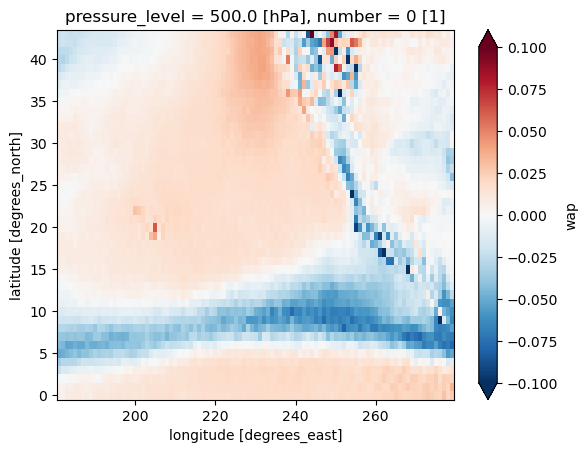

In [143]:
# [site_data_ar[i].expand_dims(["latitude", "longitude"]) for i in range(len(site_data_ar))]
combined_data.wap.sel(pressure_level = 500).plot(vmin = -.1, vmax = .1, cmap = "RdBu_r")

In [134]:
combined_data

<xarray.Dataset> Size: 10MB
Dimensions:         (latitude: 44, longitude: 99, pressure_level: 37)
Coordinates:
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
  * latitude        (latitude) float64 352B 0.0 1.0 2.0 3.0 ... 41.0 42.0 43.0
  * longitude       (longitude) float64 792B 181.0 182.0 183.0 ... 278.0 279.0
    number          int64 8B 0
Data variables: (12/17)
    zg              (latitude, longitude, pressure_level) float32 645kB 812.3...
    ta              (latitude, longitude, pressure_level) float32 645kB 299.7...
    rho             (latitude, longitude, pressure_level) float64 1MB 1.162 ....
    ua              (latitude, longitude, pressure_level) float32 645kB -5.12...
    va              (latitude, longitude, pressure_level) float32 645kB 0.534...
    wa              (latitude, longitude, pressure_level) float32 645kB 0.000...
    ...              ...
    z               (latitude, longitude, pressure_level) float32 645kB 82.82...
    wap             (latitude, longitude, pressure_level) float64 1MB 0.00015...
    tntva           (latitude, longitude, pressure_level) float32 645kB -1.30...
    tnhusva         (latitude, longitude, pressure_level) float32 645kB -1.00...
    tntha           (latitude, longitude, pressure_level) float32 645kB 1.534...
    tnhusha         (latitude, longitude, pressure_level) float32 645kB 4.088...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-30T04:48 GRIB to CDM+CF via cfgrib-0.9.1...

<xarray.Dataset> Size: 10MB
Dimensions:         (latitude: 44, longitude: 99, pressure_level: 37)
Coordinates:
  * pressure_level  (pressure_level) float64 296B 1e+03 975.0 950.0 ... 2.0 1.0
  * latitude        (latitude) float64 352B 0.0 1.0 2.0 3.0 ... 41.0 42.0 43.0
  * longitude       (longitude) float64 792B 181.0 182.0 183.0 ... 278.0 279.0
    number          int64 8B 0
Data variables: (12/17)
    zg              (latitude, longitude, pressure_level) float32 645kB 812.3...
    ta              (latitude, longitude, pressure_level) float32 645kB 299.7...
    rho             (latitude, longitude, pressure_level) float64 1MB 1.162 ....
    ua              (latitude, longitude, pressure_level) float32 645kB -5.12...
    va              (latitude, longitude, pressure_level) float32 645kB 0.534...
    wa              (latitude, longitude, pressure_level) float32 645kB 0.000...
    ...              ...
    z               (latitude, longitude, pressure_level) float32 645kB 82.82...
    wap             (latitude, longitude, pressure_level) float64 1MB 0.00015...
    tntva           (latitude, longitude, pressure_level) float32 645kB -1.30...
    tnhusva         (latitude, longitude, pressure_level) float32 645kB -1.00...
    tntha           (latitude, longitude, pressure_level) float32 645kB 1.534...
    tnhusha         (latitude, longitude, pressure_level) float32 645kB 4.088...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-30T04:48 GRIB to CDM+CF via cfgrib-0.9.1...

Text(0.5, 1.0, 'WAP (Pa/s)')

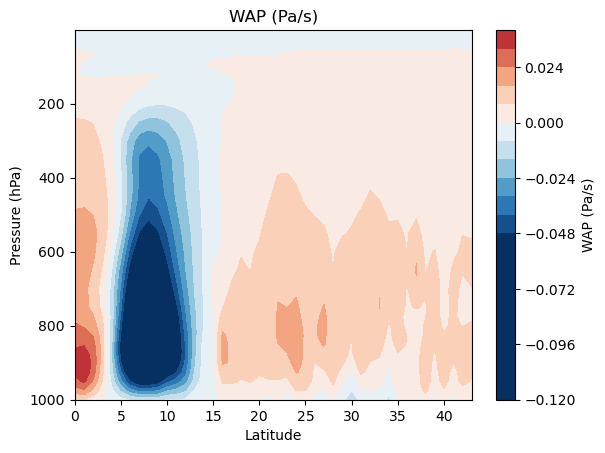

In [133]:
import matplotlib.pyplot as plt
wap_mean = combined_data.wap.mean(dim="longitude")

# Plot using contourf (or pcolormesh for a heatmap-like plot)
contour = plt.contourf(
    combined_data.latitude.values,
    combined_data.pressure_level.values,
    np.transpose(wap_mean.values),
    levels=20,  # Number of contour levels
    vmin = -.05,
    vmax = .05, 
    cmap="RdBu_r"
)
plt.gca().invert_yaxis()  # Invert y-axis for pressure (higher pressures at the bottom)
cbar = plt.colorbar(contour, label="WAP (Pa/s)")

plt.xlabel("Latitude")
plt.ylabel("Pressure (hPa)")
plt.title("WAP (Pa/s)")

In [172]:
# units dictionary
units_dict = {
    "ta": "K",
    "ua": "m/s",
    "va": "m/s",
    "wa": "m/s",
    "hus": "kg/kg",
    "hfls": "W/m²",
    "hfss": "W/m²",
    "rsdt": "W/m²",
    "ts": "K",
    "zg": "m",
    "wap": "Pa/s",
    "tntva": "K/s",
    "tnhusva": "kg/kg/s",
    "tntha": "K/s",
    "tnhusha": "kg/kg/s"
}

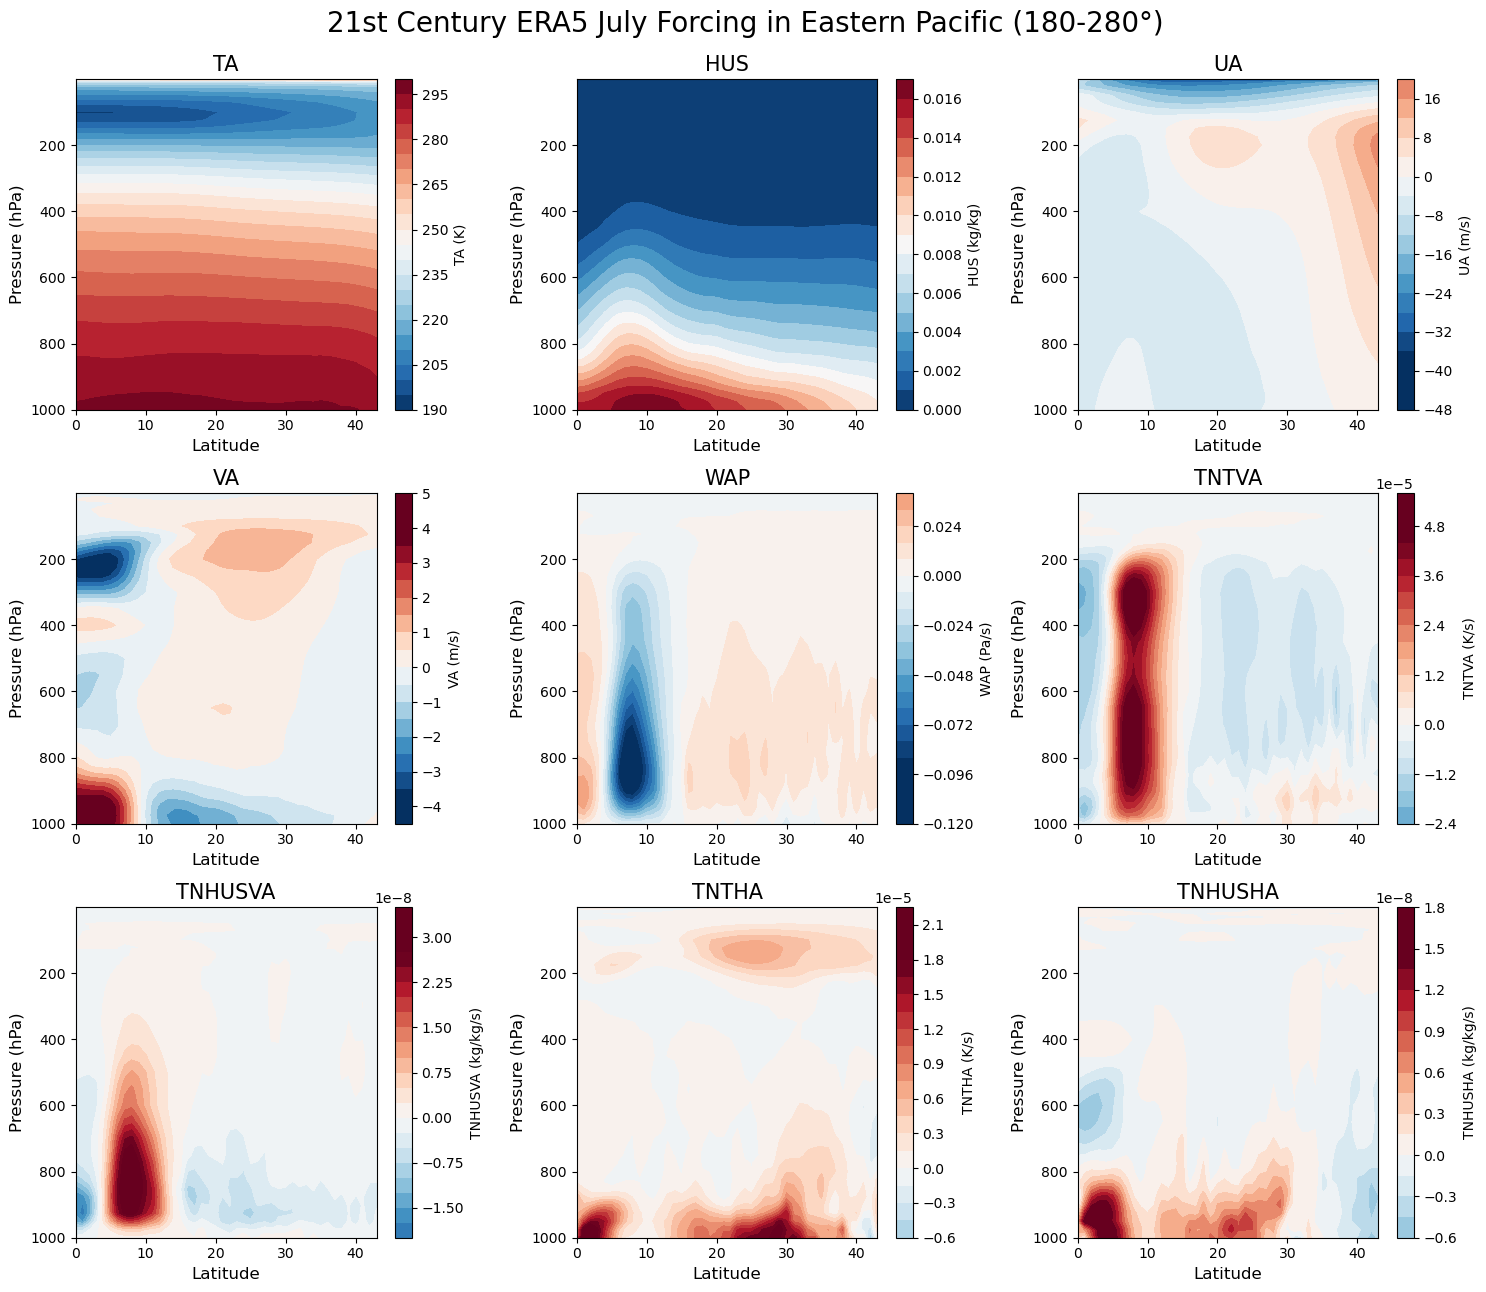

In [173]:
fig, ax = plt.subplots(3, 3, figsize = (15, 13))

for i, var in enumerate(["ta", "hus", "ua", "va", "wap", "tntva", "tnhusva", "tntha", "tnhusha"]):
    var_mean = combined_data[var].mean(dim="longitude")

    if var in ["ua", "va", "wap", "tntha", "tnhusha", "tntva", "tnhusva"]:
        # center range around 0
        vmin = -np.abs(var_mean).max() * .8
        vmax = np.abs(var_mean).max() *.8 
        contour = ax[i//3, i%3].contourf(
            combined_data.latitude.values,
            combined_data.pressure_level.values,
            np.transpose(var_mean.values),
            levels=20,  # Number of contour levels
            vmin = vmin,
            vmax = vmax,
            cmap="RdBu_r"
        )
    else:
        contour = ax[i//3, i%3].contourf(
            combined_data.latitude.values,
            combined_data.pressure_level.values,
            np.transpose(var_mean.values),
            levels=20,  # Number of contour levels
            cmap="RdBu_r"
        )
    ax[i//3, i%3].invert_yaxis()  # Invert y-axis for pressure (higher pressures at the bottom)
    cbar = plt.colorbar(contour, ax = ax[i//3, i%3], label=var.upper() + f" ({units_dict[var]})")

    ax[i//3, i%3].set_xlabel("Latitude", fontsize = 12)
    ax[i//3, i%3].set_ylabel("Pressure (hPa)", fontsize = 12)
    ax[i//3, i%3].set_title(var.upper(), fontsize = 15)
plt.suptitle("21st Century ERA5 July Forcing in Eastern Pacific (180-280°)", y = .99, fontsize = 20)
plt.tight_layout();

plt.savefig("/Users/julianschmitt/Documents/Research/loss/figures/nov24/July_era5_forcing_north_pacific.png", dpi = 250)